In [1]:
import os; os.environ["CUDA_VISIBLE_DEVICES"]="3"
import re, math, random, datetime, time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import imgaug.augmenters as iaa

import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Input, Lambda, concatenate, Conv2D, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam 

path = "/home/bobhjchao/keypoint/hrnet/input_20211209_sep"
print( len(list(filter(lambda s: ".jpg" in s, os.listdir(f"{path}/data")))) )
print( len(list(filter(lambda s: ".xml" in s, os.listdir(f"{path}/data")))) )
# list(filter(lambda s: (".jpg" not in s) and (".xml" not in s), os.listdir(f"{path}/data")))

549
549


In [2]:
sigma = 5
def gauss(k, i, _):
    channel, row, col = i, k%(224*224)//224, k%(224*224)%224
    return math.exp(-1/(2*sigma**2)*( (col-keypoint[channel][0])**2+(row-keypoint[channel][1])**2 ))*255

os.system(f"mkdir {path}/heatmap1 {path}/heatmap2 {path}/heatmap3")
imgPathList=list(map(lambda s:f"{path}/data/{s}",filter(lambda s:"jpg" in s, os.listdir(f"{path}/data"))))
for i,imgPath in enumerate(imgPathList):
    print(f"\r{i+1}/{len(imgPathList)}", end=''); continue
    rawImg = cv2.imread(imgPath)
    img = cv2.resize(rawImg, (224,224))
    with open(imgPath.replace('.jpg','.xml'), "r") as f:
        txt = f.read()
        up_xmin, mi_xmin, do_xmin = re.findall("<xmin>([0-9]*)</xmin>", txt)
        up_xmax, mi_xmax, do_xmax = re.findall("<xmax>([0-9]*)</xmax>", txt)
        up_ymin, mi_ymin, do_ymin = re.findall("<ymin>([0-9]*)</ymin>", txt)
        up_ymax, mi_ymax, do_ymax = re.findall("<ymax>([0-9]*)</ymax>", txt)
    upx = (int(up_xmin)+int(up_xmax))/2 /rawImg.shape[1] * 224
    mix = (int(mi_xmin)+int(mi_xmax))/2 /rawImg.shape[1] * 224
    dox = (int(do_xmin)+int(do_xmax))/2 /rawImg.shape[1] * 224
    upy = (int(up_ymin)+int(up_ymax))/2 /rawImg.shape[0] * 224
    miy = (int(mi_ymin)+int(mi_ymax))/2 /rawImg.shape[0] * 224
    doy = (int(do_ymin)+int(do_ymax))/2 /rawImg.shape[0] * 224
    keypoint = [(upx,upy), (mix,miy), (dox,doy)]
    
    for i in range(3):
        heatmap1D = np.zeros(224*224*1)
        heatmap1D = np.vectorize(gauss)(range(224*224*1), [i]*(224*224*1), heatmap1D )
        heatmap = heatmap1D[:224*224].reshape(224,224,1)                   
        cv2.imwrite(imgPath.replace('data',f'heatmap{i+1}'), heatmap)

print( [len(os.listdir(f"{path}/{folder}")) for folder in ["data","heatmap1","heatmap2","heatmap3"] ])

549/549[1099, 549, 549, 549]


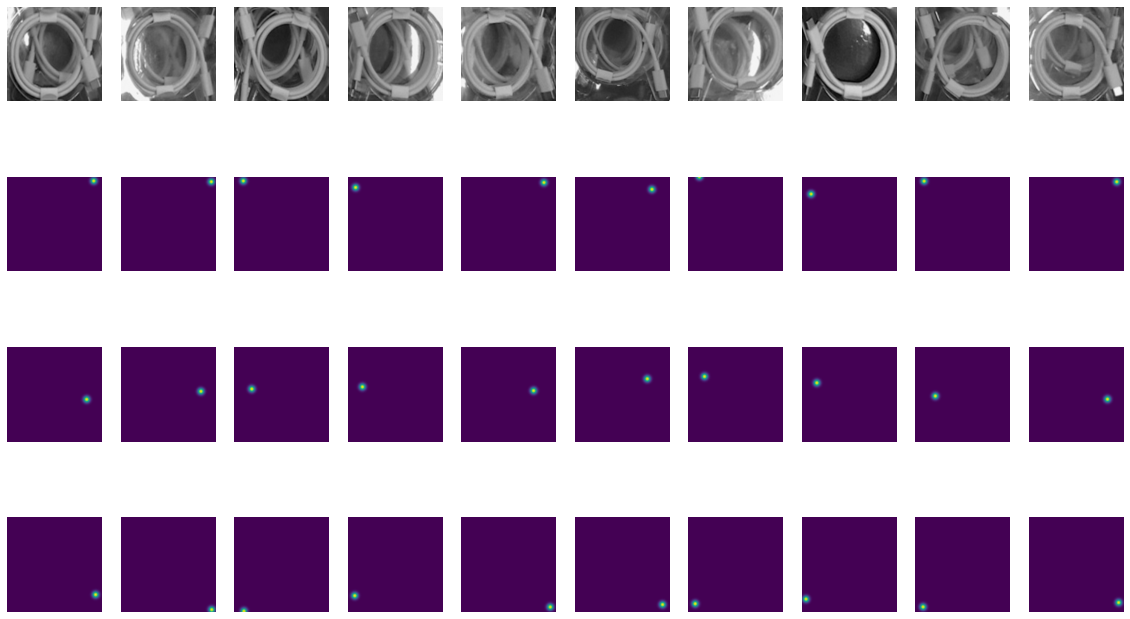

In [20]:
random.shuffle(imgPathList)
plt.figure(figsize=(20,12))
for i in range(10):
    plt.subplot(4,10,i+1)
    plt.imshow( cv2.imread(imgPathList[i]) )
    plt.axis('off')
    plt.subplot(4,10,10+i+1)
    plt.imshow( cv2.imread(imgPathList[i].replace("data","heatmap1"),cv2.IMREAD_GRAYSCALE) )
    plt.axis('off')
    plt.subplot(4,10,20+i+1)
    plt.imshow( cv2.imread(imgPathList[i].replace("data","heatmap2"),cv2.IMREAD_GRAYSCALE) )
    plt.axis('off')
    plt.subplot(4,10,30+i+1)
    plt.imshow( cv2.imread(imgPathList[i].replace("data","heatmap3"),cv2.IMREAD_GRAYSCALE) )
    plt.axis('off')
plt.show()

In [25]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, image_keys, aug, batch_size=4, train=True):
        self.image_keys = image_keys # list[str] # all indices
        self.aug = aug               # aug
        self.batch_size = batch_size # int
        self.train = train
        self.on_epoch_end()
    def __len__(self):
        return len(self.image_keys) // self.batch_size
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_keys)) # np.array([int]) # all indices
        if self.train:
            np.random.shuffle(self.indexes)
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size] # np.array([int]) # indices of a batch
        image_keys_temp = [self.image_keys[k] for k in indexes]                         # np.array([str]) # imgName of a batch
        (images, keypoints) = self.__data_generation(image_keys_temp)
        return (images, keypoints)
    def __data_generation(self, image_keys_temp):
        batch_images = np.empty( (self.batch_size, 224, 224, 3), dtype="float" )
        batch_hm1  = np.empty( (self.batch_size, 224, 224, 1), dtype="float" )
        batch_hm2  = np.empty( (self.batch_size, 224, 224, 1), dtype="float" )
        batch_hm3   = np.empty( (self.batch_size, 224, 224, 1), dtype="float" )
        for i,imgPath in enumerate(image_keys_temp):
            rawImg = cv2.imread(imgPath)
            hm1  = cv2.imread(imgPath.replace('data','heatmap1'), cv2.IMREAD_GRAYSCALE).reshape(224,224,1)
            hm2  = cv2.imread(imgPath.replace('data','heatmap2'), cv2.IMREAD_GRAYSCALE).reshape(224,224,1)
            hm3   = cv2.imread(imgPath.replace('data','heatmap3'), cv2.IMREAD_GRAYSCALE).reshape(224,224,1)

            rd = random.random()
            op = (rd>=0.7) + (rd>=0.8) + (rd>=0.9) 

            aug = iaa.Sequential([
                iaa.Resize(224, interpolation="linear"),
                iaa.Sometimes( int(op==1), iaa.Affine(scale=(0.8,0.8))),
                iaa.Sometimes( int(op==2), iaa.Affine(rotate=-10, scale=(0.7,0.7))),
                iaa.Sometimes( int(op==3), iaa.Affine(rotate=10, scale=(0.7,0.7))),
            ])

            augImg = aug.augment_image(rawImg)
            augHm1 = aug.augment_image(hm1)
            augHm2 = aug.augment_image(hm2)
            augHm3 = aug.augment_image(hm3)
            batch_images[i]  = (augImg-augImg.min())/(augImg.max()-augImg.min())
            batch_hm1[i] = (augHm1-augHm1.min())/(augHm1.max()-augHm1.min())
            batch_hm2[i] = (augHm2-augHm2.min())/(augHm2.max()-augHm2.min())
            batch_hm3[i] = (augHm3-augHm3.min())/(augHm3.max()-augHm3.min())
        return (batch_images, (batch_hm1,batch_hm2,batch_hm3))

In [3]:
train_keys, val_keys = imgPathList[:int(0.8*len(imgPathList))], imgPathList[int(0.8*len(imgPathList)):]

train_2D_keys = [ list(filter(lambda s:f"type{i}" in s, train_keys)) for i in range(3) ]
dataNumList = [ len(train_2D_keys[i]) for i in range(3) ]
print(dataNumList)
for i in range(3):
    for _ in range(max(dataNumList)-dataNumList[i]):
        train_keys.append( train_2D_keys[i][random.randint(0,dataNumList[i]-1)] )
random.shuffle(train_keys[:])
        
print(len(train_keys), len(val_keys))

[293, 91, 55]
879 110


In [27]:
train_dataset = KeyPointsDataset(train_keys, aug=None)
validation_dataset = KeyPointsDataset(val_keys, aug=None, train=False)
print(len(train_dataset), len(validation_dataset))

228 27


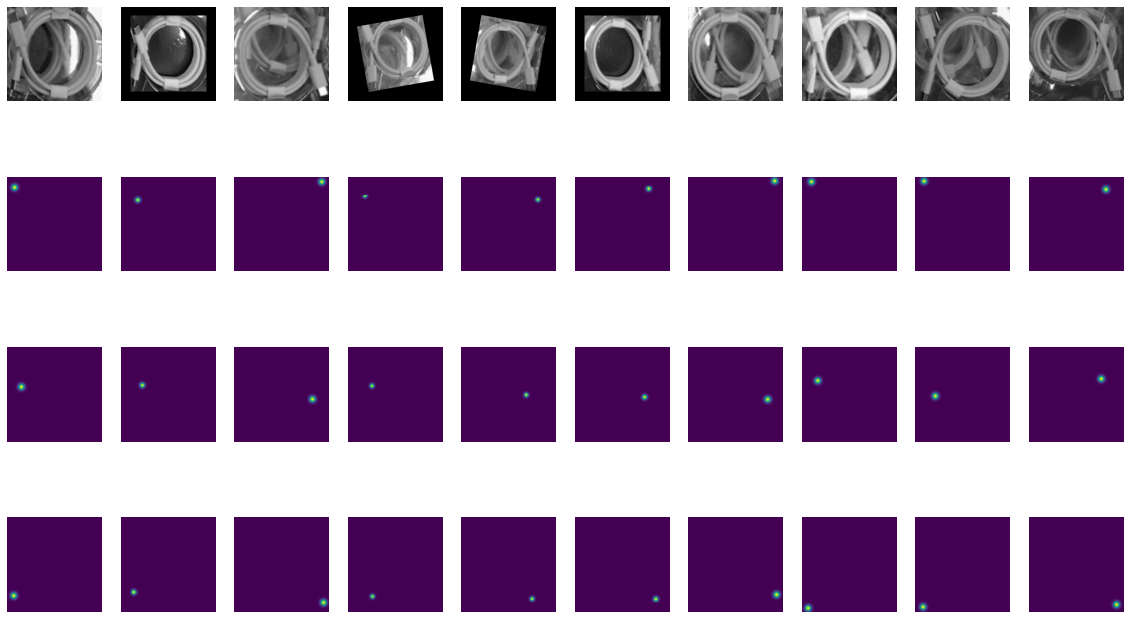

In [28]:
example_dataset = KeyPointsDataset(train_keys[:16], batch_size=10, aug=None)
plt.figure(figsize=(20,12))
for batch in example_dataset: # batch[0].shape=(10,224,224,3) # batch1:tup
    for i in range(10):
        plt.subplot(4,10,i+1)
        plt.imshow(batch[0][i])
        plt.axis('off')
        plt.subplot(4,10,i+11)
        plt.imshow(batch[1][0][i])
        plt.axis('off')
        plt.subplot(4,10,i+21)
        plt.imshow(batch[1][1][i])
        plt.axis('off')
        plt.subplot(4,10,i+31)
        plt.imshow(batch[1][2][i])
        plt.axis('off')
plt.show()

In [ ]:
# algorithm

In [6]:
pretrain = True

if pretrain:
#     from tensorflow.compat.v1 import ConfigProto
#     from tensorflow.compat.v1 import InteractiveSession
#     config = ConfigProto()
#     config.gpu_options.allow_growth = True
#     session = InteractiveSession(config=config)
    vgg19 = VGG19(input_shape=(224,224,3))
    model = load_model(f"{path}/model_12-18.h5", custom_objects={"tf":tf})
else:
    vgg19 = VGG19(input_shape=(224,224,3)) # include_top=True, weights='imagenet'
    vgg19.trainable = False
    pre224 = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[2].output)
    pre112 = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[5].output)
    pre56  = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[10].output)
    pre28  = Lambda(lambda image: tf.image.resize(image, (224,224)))(vgg19.layers[15].output)
    x = concatenate([vgg19.input, pre224, pre112, pre56, pre28])
    x = Conv2D(64, (1,1), padding='same', activation='relu')(x)

    def subnet(x): # https://arxiv.org/pdf/1902.09212.pdf
        h00 = Conv2D(64, (3,3), padding='same', activation='relu')(x)
        h00 = Conv2D(64, (3,3), padding='same', activation='relu')(h00)
        #
        h01 = Conv2D(64, (3,3), padding='same', activation='relu')(h00)
        h01 = Conv2D(64, (3,3), padding='same', activation='relu')(h01)
        h01d = Conv2D(64, (3,3), padding='same', strides=2, activation='relu')(h01)
        h11 = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(h00)
        h11 = Conv2D(64, (3,3), padding='same', activation='relu')(h11)
        h11u = UpSampling2D((2,2))(h11)
        #
        h02 = concatenate([h01,h11u])  
        h02 = Conv2D(64, (1,1), padding='same', activation='relu')(h02)
        h02 = Conv2D(64, (3,3), padding='same', activation='relu')(h02)
        h02d = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(h02)
        h02dd = Conv2D(64, (3,3), strides=4, padding='same', activation='relu')(h02)   
        h12 = concatenate([h01d,h11])
        h12 = Conv2D(64, (1,1), padding='same', activation='relu')(h12)
        h12 = Conv2D(64, (3,3), padding='same', activation='relu')(h12)
        h12u = UpSampling2D((2,2))(h12)
        h12d = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(h12)
        #
        h03 = concatenate([h02,h12u])
        h03 = Conv2D(64, (1,1), padding='same', activation='relu')(h03)
        h03 = Conv2D(64, (3,3), padding='same', activation='relu')(h03)
        #h03d = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(h03)
        #h03dd = Conv2D(64, (3,3), strides=4, padding='same', activation='relu')(h03)    
        h13 = concatenate([h02d,h12])
        h13 = Conv2D(64, (1,1), padding='same', activation='relu')(h13)
        h13 = Conv2D(64, (3,3), padding='same', activation='relu')(h13)
        h13u = UpSampling2D((2,2))(h13)
        #h13d = Conv2D(64, (3,3), strides=2, padding='same', activation='relu')(h13)
        h23 = concatenate([h02dd,h12d])
        h23 = Conv2D(64, (1,1), padding='same', activation='relu')(h23)
        h23 = Conv2D(64, (3,3), padding='same', activation='relu')(h23)
        #h23u = UpSampling2D((2,2))(h23)
        h23uu = UpSampling2D((4,4))(h23)
        #
        h04 = concatenate([h03,h13u,h23uu])    
        h04 = Conv2D(64, (1,1), padding='same', activation='relu')(h04)
        h04 = Conv2D(64, (3,3), padding='same', activation='relu')(h04)
        h04 = Conv2D(1, (3,3), padding='same')(h04)
        return h04

    kp1 = subnet(x)
    kp2 = subnet(x)
    kp3 = subnet(x)
    model = Model(vgg19.input, [kp1,kp2,kp3])

model.summary()
loss, val_loss = [], []

def infTime(model):
    L = np.random.random((1,224,224,3))
    s = time.time()
    model.predict(L)
    return round(time.time()-s,2)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_6[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [8]:
infTime(model), infTime(vgg19)

(0.07, 0.03)

In [ ]:
# def myloss(y_true, y_pred, model=modelDis, batch_size=4): # 2 HMs comparison # shape=(batch_size,224,224,3)   
#     loss = K.mean( K.square(y_pred-y_true), axis=[1,2,3])
#     dis_y_true = modelDis(y_true)        # feature list # shape=(batch_size,n*n*channels)
#     dis_y_pred = modelDis(y_pred)
#     for i in range( len(dis_y_true) ):   # sum over each discriminator output layer
#         loss = loss + K.mean(K.square(dis_y_pred[i]-dis_y_true[i]),axis=[1,2,3]) # += is unavailable
#     return loss

# modelGen.compile(optimizer="Adam", loss=myloss)
# start = time.time()
# modelGen.fit(np.random.random((8,224,224,3)), np.random.random((8,224,224,3)), epochs=10, batch_size=4)
# print(time.time()-start)

In [35]:
model.compile(optimizer=Adam(learning_rate=0.5*1e-4), loss=['mse','mse','mse'], loss_weights=[1,1,1])
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=10)
loss += history.history["loss"]
val_loss += history.history["val_loss"]

Epoch 1/10
228/228 [==============================] - 45s 197ms/step - loss: 7.6892e-04 - conv2d_259_loss: 2.1312e-04 - conv2d_282_loss: 3.5539e-04 - conv2d_305_loss: 2.0041e-04 - val_loss: 0.0013 - val_conv2d_259_loss: 3.2150e-04 - val_conv2d_282_loss: 6.3685e-04 - val_conv2d_305_loss: 3.5269e-04
Epoch 2/10
228/228 [==============================] - 44s 192ms/step - loss: 7.0108e-04 - conv2d_259_loss: 1.9323e-04 - conv2d_282_loss: 3.3298e-04 - conv2d_305_loss: 1.7487e-04 - val_loss: 0.0013 - val_conv2d_259_loss: 3.8587e-04 - val_conv2d_282_loss: 6.3911e-04 - val_conv2d_305_loss: 3.2324e-04
Epoch 3/10
228/228 [==============================] - 44s 192ms/step - loss: 6.6893e-04 - conv2d_259_loss: 1.8481e-04 - conv2d_282_loss: 3.1816e-04 - conv2d_305_loss: 1.6596e-04 - val_loss: 0.0013 - val_conv2d_259_loss: 3.5149e-04 - val_conv2d_282_loss: 6.0141e-04 - val_conv2d_305_loss: 3.4948e-04
Epoch 4/10
228/228 [==============================] - 44s 192ms/step - loss: 5.9745e-04 - conv2d_259_lo

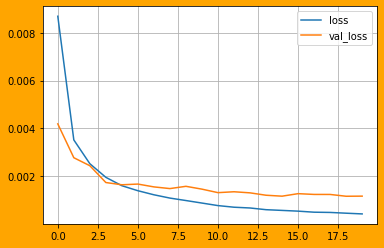

In [36]:
fig = plt.figure()
fig.set_facecolor("orange")
plt.plot( loss )
plt.plot( val_loss )
plt.legend( labels=["loss","val_loss"] )
plt.savefig(f"{path}/loss.jpg")
plt.grid('on')
plt.show()

In [45]:
# prediction

In [10]:
imgs = np.zeros((len(val_keys),224,224,3)).astype(int)
hms = np.zeros((len(val_keys),224,224,3)).astype(int)
for i,key in enumerate(val_keys):
    imgs[i] = cv2.resize(cv2.imread(key), (224,224))
    hms[i][:,:,0]  = cv2.imread(key.replace("data","heatmap1"), cv2.IMREAD_GRAYSCALE)
    hms[i][:,:,1]  = cv2.imread(key.replace("data","heatmap2"), cv2.IMREAD_GRAYSCALE)
    hms[i][:,:,2]  = cv2.imread(key.replace("data","heatmap3"), cv2.IMREAD_GRAYSCALE)
pred = model.predict( imgs/255. )
print(len(pred), pred[0].shape)

minConfDict = {"imgName":[], "minConf":[]}
for i,key in enumerate(val_keys):
    minConfDict["imgName"].append( key.split("/")[-1] )
    minConfDict["minConf"].append( min([round(pred[j].max(),2) for j in range(3)]) )
minConf_df = pd.DataFrame(minConfDict)
minConf_df = minConf_df.sort_values(by="minConf").reset_index()
minConf_df

3 (110, 224, 224, 1)


,index,imgName,minConf
0,0,type0_20211109-160430_00008_color_2.jpg,1.05
1,79,type0_20210906-135444_00007_color_9.jpg,1.05
2,78,type0_a12.jpg,1.05
3,77,type0_20211109-150455_00006_color_1.jpg,1.05
4,76,type0_b45.jpg,1.05
...,...,...,...
105,31,type1_20211109-180923_00006_color_4.jpg,1.05
106,30,type2_20211023-140946_00002_color_7_.jpg,1.05
107,29,type0_c21.jpg,1.05
108,40,type1_20211109-114404_00003_color_3.jpg,1.05


In [11]:
# upidx, mididx, downidx = predhm[:,:,0].argmax(), predhm[:,:,1].argmax(), predhm[:,:,2].argmax()
# upy, upx, midy, midx, downy, downx = upidx//224, upidx%224, mididx//224, mididx%224, downidx//224, downidx%224
# up:0~100; mid:60~165; down:120~224
# def getKP(predhm): # input.shape=(224,224,3)
#     isUpLeft, isMidLeft, isDownLeft = predhm[:,:,0].argmax()%224<112, predhm[:,:,1].argmax()%224<112, predhm[:,:,0].argmax()%224<112
#     if int(isUpLeft)+int(isMidLeft)+int(isDownLeft) >= 2:
#         upy   = 0   + predhm[:125,:112,0].argmax()//112
#         upx   = 0   + predhm[:125,:112,0].argmax()%112
#         midy  = 60  + predhm[60:165,:112,1].argmax()//112
#         midx  = 0   + predhm[60:165,:112,1].argmax()%112
#         downy = 120 + predhm[120:,:112,2].argmax()//112
#         downx = 0   + predhm[120:,:112,2].argmax()%112
#     else:
#         upy   = 0   + predhm[:125,112:,0].argmax()//112
#         upx   = 112 + predhm[:125,112:,0].argmax()%112
#         midy  = 60  + predhm[60:165,112:,1].argmax()//112
#         midx  = 112 + predhm[60:165,112:,1].argmax()%112
#         downy = 120 + predhm[120:,112:,2].argmax()//112
#         downx = 112 + predhm[120:,112:,2].argmax()%112
#     return upy, upx, midy, midx, downy, downx

def getKP(predhm1, predhm2, predhm3): # input.shape=(224,224,1)
    upidx, mididx, downidx = predhm1.argmax(), predhm2.argmax(), predhm3.argmax()
    upy, upx, midy, midx, downy, downx = upidx//224, upidx%224, mididx//224, mididx%224, downidx//224, downidx%224
    isUpLeft, isMidLeft, isDownLeft = upx<112, midx<112, downx<112
    if int(isUpLeft)+int(isMidLeft)+int(isDownLeft) == 2:
        if not isUpLeft:
            upy = 0 + predhm1[:125,:112].argmax()//112
            upx = 0 + predhm1[:125,:112].argmax()%112
        elif not isMidLeft:
            midy  = 60  + predhm2[60:165,:112].argmax()//112
            midx  = 0   + predhm2[60:165,:112].argmax()%112
        else:
            downy = 120 + predhm2[120:,:112].argmax()//112
            downx = 0   + predhm2[120:,:112].argmax()%112
    elif int(isUpLeft)+int(isMidLeft)+int(isDownLeft) == 1:
        if isUpLeft:
            upy   = 0   + predhm1[:125,112:].argmax()//112
            upx   = 112 + predhm1[:125,112:].argmax()%112
        elif isMidLeft:
            midy  = 60  + predhm2[60:165,112:].argmax()//112
            midx  = 112 + predhm2[60:165,112:].argmax()%112
        else:
            downy = 120 + predhm3[120:,112:].argmax()//112
            downx = 112 + predhm3[120:,112:].argmax()%112
    return upy, upx, midy, midx, downy, downx

type0_20211109-160430_00008_color_2.jpg  |  1.05


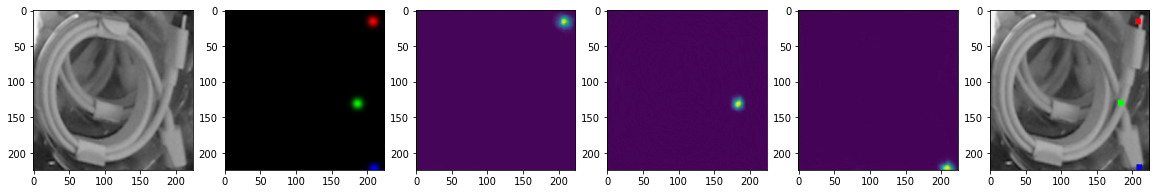

type0_20210906-135444_00007_color_9.jpg  |  1.05


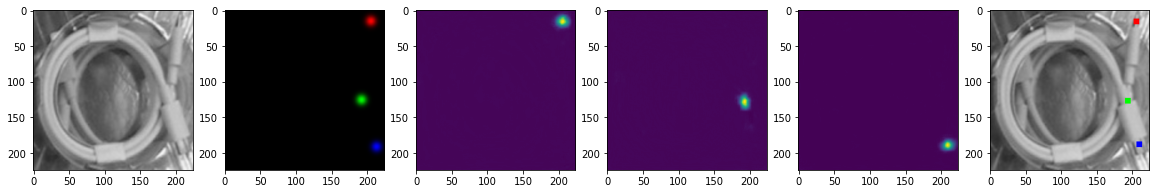

type0_a12.jpg  |  1.05


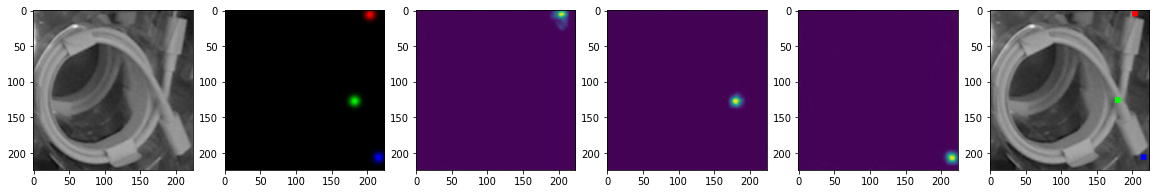

type0_20211109-150455_00006_color_1.jpg  |  1.05


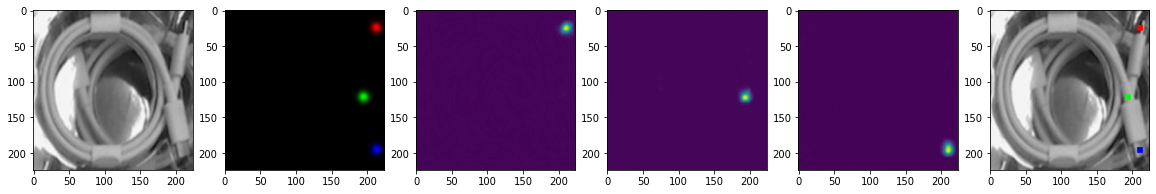

type0_b45.jpg  |  1.05


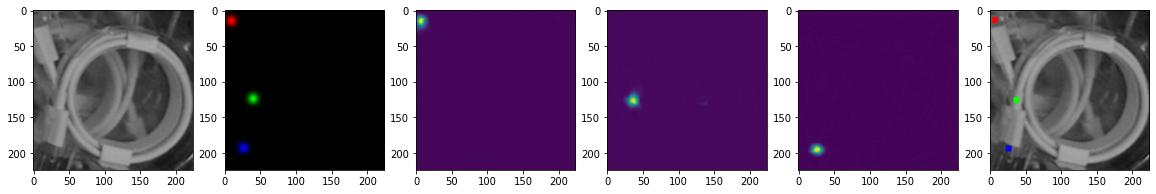

In [12]:
for i in range(0,5): #len(minConf_df)):
    print(minConf_df["imgName"][i], " | ", round(minConf_df["minConf"][i],2))
    oidx = minConf_df["index"][i]
    predhm1, predhm2, predhm3 = pred[0][oidx], pred[1][oidx], pred[2][oidx]    
    predhm1 = (predhm1-predhm1.min())/(predhm1.max()-predhm1.min())
    predhm2 = (predhm2-predhm2.min())/(predhm2.max()-predhm2.min())
    predhm3 = (predhm3-predhm3.min())/(predhm3.max()-predhm3.min())
    
    upy, upx, midy, midx, downy, downx = getKP( predhm1, predhm2, predhm3 )
    #upidx, mididx, downidx = predhm1.argmax(), predhm2.argmax(), predhm3.argmax()
    #upy, upx, midy, midx, downy, downx = upidx//224, upidx%224, mididx//224, mididx%224, downidx//224, downidx%224
    #upy, upx, midy, midx, downy, downx = getKP( predhm )

    imgkp = imgs[oidx].copy()
    imgkp[max(0,upy-4):min(224,upy+4), max(0,upx-4):min(224,upx+4), 0] = 255
    imgkp[max(0,upy-4):min(224,upy+4), max(0,upx-4):min(224,upx+4), 1] = 0
    imgkp[max(0,upy-4):min(224,upy+4), max(0,upx-4):min(224,upx+4), 2] = 0
    imgkp[max(0,midy-4):min(224,midy+4), max(0,midx-4):min(224,midx+4), 0] = 0
    imgkp[max(0,midy-4):min(224,midy+4), max(0,midx-4):min(224,midx+4), 1] = 255
    imgkp[max(0,midy-4):min(224,midy+4), max(0,midx-4):min(224,midx+4), 2] = 0
    imgkp[max(0,downy-4):min(224,downy+4), max(0,downx-4):min(224,downx+4), 0] = 0
    imgkp[max(0,downy-4):min(224,downy+4), max(0,downx-4):min(224,downx+4), 1] = 0
    imgkp[max(0,downy-4):min(224,downy+4), max(0,downx-4):min(224,downx+4), 2] = 255

    plt.figure(figsize=(20,5))
    plt.subplot(1,6,1)
    plt.imshow(imgs[oidx])

    plt.subplot(1,6,2)
    plt.imshow( hms[oidx] )
    
    plt.subplot(1,6,3)
    plt.imshow(predhm1)
    
    plt.subplot(1,6,4)
    plt.imshow(predhm2)
    
    plt.subplot(1,6,5)
    plt.imshow(predhm3)
    
    plt.subplot(1,6,6)
    plt.imshow(imgkp)

    plt.show()

In [54]:
model.save(f"{path}/model_{str(datetime.datetime.now())[5:10]}.h5")